## Heuristic Used:  
After first iteration, fixing those x variables for which MC constraint were satisfied.

and Finally:
Optimising the model again with LR relaxation.   
with constraints of KP (only those active for which the variables wornt have been fixed).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import log
import shutil
import sys
import os.path
#from pyomo.environ import *
import pyomo.environ as pe
import pyomo.opt as po

In [2]:
m = pe.ConcreteModel()
# Defining data

m.M = pe.RangeSet(1,8)
m.J = pe.RangeSet(1,24)

data = [36, 35, 38, 34, 32, 34, 31, 34]
# Create a dictionary with keys from 1 to 8 and corresponding values from list b
b = {i: data[i-1] for i in m.M}

data = [
    25, 23, 20, 16, 19, 22, 20, 16, 15, 22, 15, 21, 20, 23, 20, 22, 19, 25, 25, 24, 21, 17, 23, 17,
    16, 19, 22, 22, 19, 23, 17, 24, 15, 24, 18, 19, 20, 24, 25, 25, 19, 24, 18, 21, 16, 25, 15, 20,
    20, 18, 23, 23, 23, 17, 19, 16, 24, 24, 17, 23, 19, 22, 23, 25, 23, 18, 19, 24, 20, 17, 23, 23,
    16, 16, 15, 23, 15, 15, 25, 22, 17, 20, 19, 16, 17, 17, 20, 17, 17, 18, 16, 18, 15, 25, 22, 17,
    17, 23, 21, 20, 24, 22, 25, 17, 22, 20, 16, 22, 21, 23, 24, 15, 22, 25, 18, 19, 19, 17, 22, 23,
    24, 21, 23, 17, 21, 19, 19, 17, 18, 24, 15, 15, 17, 18, 15, 24, 19, 21, 23, 24, 17, 20, 16, 21,
    18, 21, 22, 23, 22, 15, 18, 15, 21, 22, 15, 23, 21, 25, 25, 23, 20, 16, 25, 17, 15, 15, 18, 16,
    19, 24, 18, 17, 21, 18, 24, 25, 18, 23, 21, 15, 24, 23, 18, 18, 23, 23, 16, 20, 20, 19, 25, 21
]

# Define the dictionary
c = {}

# Populate the dictionary
index = 0
for i in range(1, 9):
    for j in range(1, 25):
        c[(i, j)] = data[index]
        index += 1  
##################
data = [
    8, 18, 22, 5, 11, 11, 22, 11, 17, 22, 11, 20, 13, 13, 7, 22, 15, 22, 24, 8, 8, 24, 18, 8,
    24, 14, 11, 15, 24, 8, 10, 15, 19, 25, 6, 13, 10, 25, 19, 24, 13, 12, 5, 18, 10, 24, 8, 5,
    22, 22, 21, 22, 13, 16, 21, 5, 25, 13, 12, 9, 24, 6, 22, 24, 11, 21, 11, 14, 12, 10, 20, 6,
    13, 8, 19, 12, 19, 18, 10, 21, 5, 9, 11, 9, 22, 8, 12, 13, 9, 25, 19, 24, 22, 6, 19, 14,
    25, 16, 13, 5, 11, 8, 7, 8, 25, 20, 24, 20, 11, 6, 10, 10, 6, 22, 10, 10, 13, 21, 5, 19,
    19, 19, 5, 11, 22, 24, 18, 11, 6, 13, 24, 24, 22, 6, 22, 5, 14, 6, 16, 11, 6, 8, 18, 10,
    24, 10, 9, 10, 6, 15, 7, 13, 20, 8, 7, 9, 24, 9, 21, 9, 11, 19, 10, 5, 23, 20, 5, 21, 6,
    9, 9, 5, 12, 10, 16, 15, 19, 18, 20, 18, 16, 21, 11, 12, 22, 16, 21, 25, 7, 14, 16, 10
]
# Define the dictionary
a = {}
# Populate the dictionary
index = 0
for i in range(1, 9):
    for j in range(1, 25):
        a[(i, j)] = data[index]
        index += 1

In [3]:
# Initialising
m.b = pe.Param(m.M, initialize=b)
m.c = pe.Param(m.M,m.J, initialize=c)
m.a = pe.Param(m.M,m.J, initialize=a)
#m.lda = pe.Param(m.J)
# lambda
l = [10 for j in m.J]
lam = {j: l[j-1] for j in m.J}

# Defining variable
m.x = pe.Var(m.M,m.J, domain=pe.Binary, initialize =0)

# Definig Objective
def objective_rule(m):
    val = sum(m.lda[j] for j in m.J) + sum(sum((m.c[i,j] - m.lda[j])*m.x[i,j] for j in m.J) for i in  m.M )
    return val

# constraints
def kp_rule(m,i):
    return sum(m.a[i,j]*m.x[i,j] for j in m.J) <= m.b[i]
#m.kp = pe.Constraint(m.M,rule=kp_rule)    

In [4]:
# This function gives optimum value of x for a particular lambda_k
def opt_x(m, lam, it):
    #lam = {j: l[j-1] for j in m.J}
    #lam = ltodict(l)
    if (it >= 1):
        m.del_component(m.lda)
        m.del_component(m.obj)
        m.del_component(m.kp)
        
    m.lda = pe.Param(m.J, initialize=lam)
    m.obj = pe.Objective(rule=objective_rule,sense=pe.maximize)
    m.kp = pe.Constraint(m.M,rule=kp_rule) 
    solver = po.SolverFactory('gurobi')
    results = solver.solve(m,tee=False)
    v = pe.value(m.obj)
    return v
    #print(pe.value(m.obj))

In [5]:
# Now, we have x^k for a particular lambda^k

# Further, Now
# At this point, one could check how many (out of j) of MC constraints does the problem NOT satisfy

# If the not satisfying answer is zero, this means: The Lagrg Solution is feasible for Primal.
def mc_const_count(m):
    it =0
    for j in m.J:
        if((sum(pe.value(m.x[i,j]) for i in m.M)) ==1):
            it = it+1
    it = 24 - it
    return it

In [6]:
                #### METHOD 2 #####

def optimise_LR(m, l, neta, opt, eps):
    #neta = 673
    it = 0
    itlr=0
    obj_list = []
    it_list = []
    cmc_list = []

    while it < 101:
        arrl = np.array(l)  # Assuming 'l' is defined elsewhere
        s = []  # Finding s^k as List
        for j in m.J:
            v = 1 - sum(pe.value(m.x[i, j]) for i in m.M)
            s.append(v)
        arrs = np.array(s)  # Converting s^k to Numpy Array
        norms = np.linalg.norm(arrs) ** 2
        if (norms == 0):
            break
        addterm = arrs * (opt - neta) / norms
        ln = arrl + eps * addterm  # Update with eps in (0,2)
        l = ln.tolist()
        lam = {j: l[j - 1] for j in m.J}
        # Update Objective and x-values
        v = opt_x(m, lam, it)  # Assuming opt_x is defined elsewhere
        obj_list.append(v)
        it_list.append(it)
        neta = v
        it += 1
        if it % 10 == 0:  # Eps reduced after every 10 Iterations
            eps *= 0.6

        cmc = mc_const_count(m)  # Assuming mc_const_count is defined elsewhere
        cmc_list.append(cmc)
        
    return neta, obj_list, it_list, cmc_list


In [7]:
 ######     RUN ENGINE     ######
 ######     HEURISTIC     ######

heu_it = 0
neta = 673
opt = 500  # Random guess - (well below LP Relaxation) Optimal Estimated
eps = 1.9

heu_it_list = []
heu_opt_list = []
while True:
    neta, obj_list, it_list, cmc_list = optimise_LR(m, l, neta, opt, eps)
    neta = neta
    for j in m.J:
        if((sum(pe.value(m.x[i,j]) for i in m.M)) ==1):
            for i in m.M:
                m.x[i,j].fix()
    m.del_component(m.lda)
    m.del_component(m.obj)
    m.del_component(m.kp)

    heu_it += 1
    heu_it_list.append(heu_it)
    heu_opt_list.append(neta)
    if (heu_it == 2):
        break

In [8]:
itlr = len(it_list)
print("Objective after",itlr,"(/100) iterations =",neta,'\n')
cmc = mc_const_count(m)
if (cmc>0):
    print("Final No. of MC constraints (out of 24) not satisfied =",cmc,'\n Thus, Langrangian solution is not feasible for Primal.')
else:
    print("Final No. of MC constraints (out of 24) not satisfied =",cmc,'\n Thus, Langrangian solution is feasible for Primal.')

Objective after 42 (/100) iterations = 563.0 

Final No. of MC constraints (out of 24) not satisfied = 0 
 Thus, Langrangian solution is feasible for Primal.


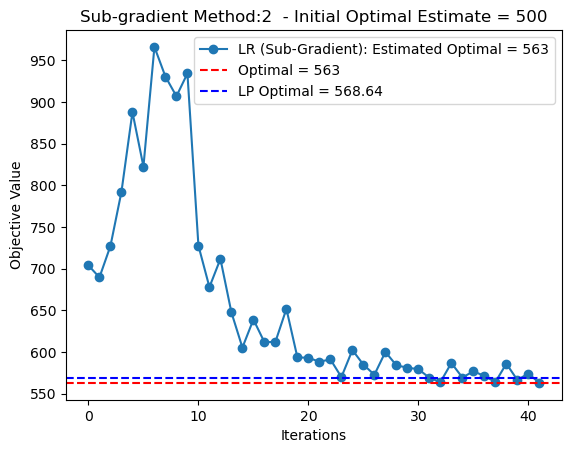

In [9]:
obj_arr = np.array(obj_list)
it_arr = np.array(it_list)
# Plotting
plt.plot(it_arr, obj_arr, marker='o',  label='LR (Sub-Gradient): Estimated Optimal = %d' % neta) # Here, x = array values, and y = indices (1 to 10)

# Adding a line y = 4
plt.axhline(y=563, color='r', linestyle='--', label='Optimal = 563') # Adds a horizontal line at y=4

plt.axhline(y=568.6463503411708, color='b', linestyle='--', label='LP Optimal = 568.64') # Adds a horizontal line at y=4


plt.xlabel('Iterations')
plt.ylabel('Objective Value')
plt.title('Sub-gradient Method:2  - Initial Optimal Estimate = %d' % opt)
plt.legend()

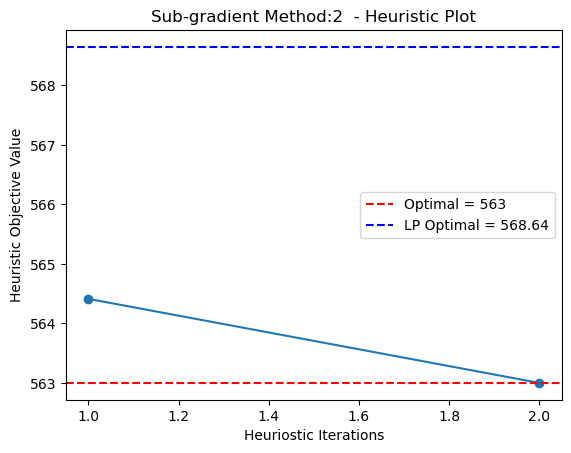

In [10]:
heu_opt_arr = np.array(heu_opt_list)
heu_it_arr = np.array(heu_it_list)
# Plotting
plt.plot(heu_it_arr, heu_opt_arr, marker='o') # Here, x = array values, and y = indices (1 to 10)

plt.axhline(y=563, color='r', linestyle='--', label='Optimal = 563') # Adds a horizontal line at y=4

plt.axhline(y=568.6463503411708, color='b', linestyle='--', label='LP Optimal = 568.64') # Adds a horizontal line at y=4


plt.xlabel('Heuriostic Iterations')
plt.ylabel('Heuristic Objective Value')
plt.title('Sub-gradient Method:2  - Heuristic Plot')
plt.legend()

In [29]:
# for j in m.J:
#     if((sum(pe.value(m.x[i,j]) for i in m.M)) ==1):
#         for i in m.M:
#             m.x[i,j].fix()